# Experimental Study Tracing Evolutionary Changes in APIs

## author: Kristiyan Michaylov
---

The following case study aims at performing an analysis on 2 Java APIs. The first API is *JUnit4*, the dataset for which is already constructed from another study. The second API is AppCompat for which we need to manually construct the dataset and analyse the evolution.

## Goal
Our goal is to investigate the feasibility of the machine learning approach. This will be achieved via the following steps:
- Read the Excel sheets and analyze the data
- Extract important features such as the "Changes" column and then perform Natural Language Processing Techniques on them, such as tokenization
- Train the algorithm to perform classification
- Check the accuracy of the algorithm
- In the final stage, be able to classify solely based on the "Changes" column
First, we start with importing the necessary libraries and defining the file paths

## Some implementation ideas/goals
 - Analyse for each category what are the most popular words, basically what infers that there is a Bug change, etc.
 - Try to predict the category of the change based on the trained data
 - At later stage, try the following: "A fascinating question will be which changes impacting the architecture of the system are represented in the release log. This way you essentially combine the two RQs and the make even more sense." For example, are breaking changes represented in the release log, etc.

In [1]:
from re import search

import pandas as pd
import re
import numpy as np
import nltk
from imblearn.over_sampling import SMOTE
from nltk import SnowballStemmer, NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import seaborn as sns
# from gensim.models import Word2Vec
from nltk.util import ngrams
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC, OneClassSVM
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, \
    confusion_matrix
# TODO: See if this is useful
import joblib

In [2]:
# file_path = "../resources/excel-sheets/JUnit.xlsx"
# sheet_name = "JUnit"
dataset_name = 'Apache Commons IO'
file_path = "../resources/datasets/Apache Commons IO.csv"

After defining our path, the first thing we do is to display part of our data, in order to check if everything is working correctly.

In [3]:
try:
    data = pd.read_csv(file_path, sep=',')
except pd.errors.ParserError:
    data = pd.read_csv(file_path, sep=';')
print(data.head())

       Year1    Year        Date        Version RELEASE  \
0  +18 years  2023.0  03.06.2023  2.13.  2.13.0   MINOR   
1  +18 years  2023.0  03.06.2023  2.13.  2.13.0   MINOR   
2  +18 years  2023.0  03.06.2023  2.13.  2.13.0   MINOR   
3  +18 years  2023.0  03.06.2023  2.13.  2.13.0   MINOR   
4  +18 years  2023.0  03.06.2023  2.13.  2.13.0   MINOR   

                                             Changes        By         .1  \
0                                                NaN       NaN        NaN   
1  Regression in FileUtils.touch() - no longer cr...  ggregory        NaN   
2  ByteArrayOrigin should be able convert a byte[...  ggregory        NaN   
3  AbstractOriginSupplier.checkOrigin() now throw...  ggregory        NaN   
4  FileAlreadyExistsException in PathUtils.create...  ggregory  exception   

                         Type  ... Unnamed: 21 Unnamed: 22  Unnamed: 23  \
0                         NaN  ...         NaN         NaN          NaN   
1                         NaN  .

### 1 Clean the Dataset and Tokenize
First we clean the data from non-alphabetic characters and then perform the tokenization of the "Changes" column. After that we remove any stopwords, so that the output is cleaner and easier to analyse in later steps

In [4]:
# Make sure to download the following
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

data.dropna(inplace=True, subset="Changes")
print(data["Changes"].head())


def find_most_common_words(count):
    cnt = Counter()
    for text in data["Changes"].values:
        for word in text.split():
            cnt[word] += 1
    return cnt.most_common(count)


def remove_frequent_words(text):
    return " ".join([word for word in str(text).split() if word not in most_frequent_words])


most_frequent_words = set([w for (w, wc) in find_most_common_words(10)])

data["Changes"] = data["Changes"].apply(lambda text: remove_frequent_words(text))

data["Tokens"] = data["Changes"].apply(word_tokenize)

stop_words = set(stopwords.words("english"))

data["Tokens"] = data["Tokens"].apply(lambda tokens: [word.lower() for word in tokens
                                                      if re.match(r'^[a-zA-Z]+$', word)
                                                      and word.casefold() not in stop_words])

data = data[data["Tokens"].apply(lambda tokens: len(tokens) > 0)]

print(data["Tokens"].head())
print("Data without stop words and solely alphabetical tokens: ")
print(data["Tokens"].head())
print(data[["Tokens", "General Category"]].to_string())


1    Regression in FileUtils.touch() - no longer cr...
2    ByteArrayOrigin should be able convert a byte[...
3    AbstractOriginSupplier.checkOrigin() now throw...
4    FileAlreadyExistsException in PathUtils.create...
5    Only read the relevant portion of a file in Ab...
Name: Changes, dtype: object
1    [regression, longer, creates, parent, director...
2    [bytearrayorigin, able, convert, byte, bytearr...
3    [throws, illegalstateexception, instead, nullp...
4    [filealreadyexistsexception, path, linkoption,...
5           [read, relevant, portion, file, long, int]
Name: Tokens, dtype: object
Data without stop words and solely alphabetical tokens: 
1    [regression, longer, creates, parent, director...
2    [bytearrayorigin, able, convert, byte, bytearr...
3    [throws, illegalstateexception, instead, nullp...
4    [filealreadyexistsexception, path, linkoption,...
5           [read, relevant, portion, file, long, int]
Name: Tokens, dtype: object
                                 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Krisi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Krisi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Krisi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Exploration and Analysis
First, we explore and visualizing parts of the dataset. Particularly, we check which words are associated to certain classes, what is their frequency and to see how data is distributed, some popular words, noises, etc. This information would later aid in deciding which parts of the data are important, why others are not.


#### Wordcloud
First we create the wordcloud to see which are the most common words. We only don't consider stopwords and punctuation symbols

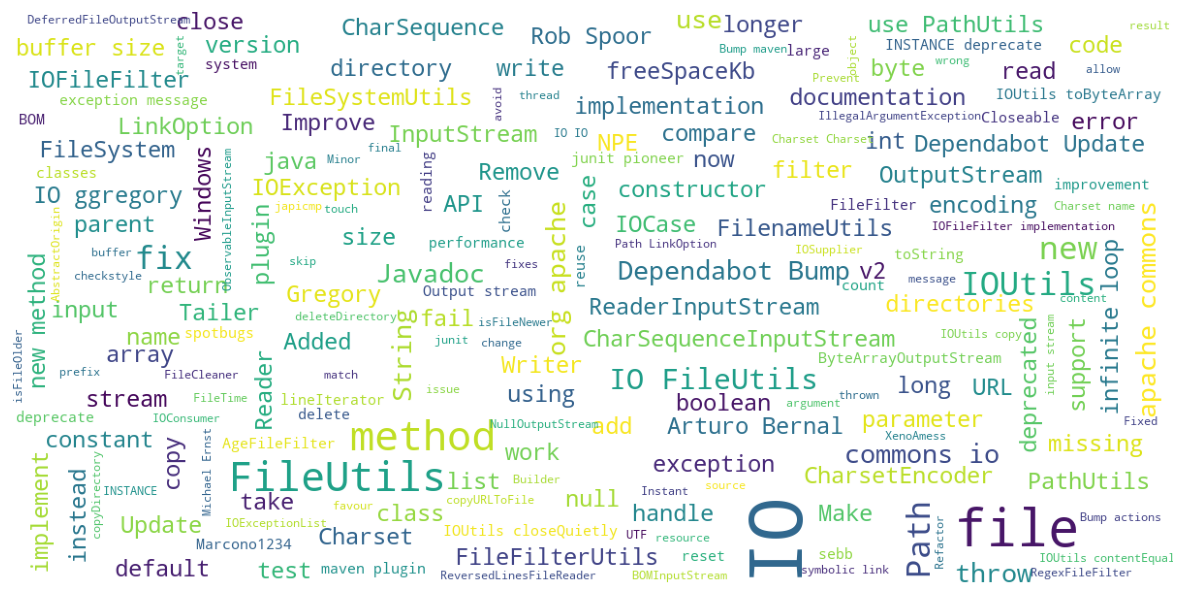

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

words = [str(item) for item in data['Changes']]
# print(words)
joined_sentences = " ".join(words)

wordcloud = WordCloud(
    background_color='white',
    stopwords=STOPWORDS,
    max_font_size=25,
    scale=3
)

wordcloud = wordcloud.generate(joined_sentences)

fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


#### Ngrams
We simply show Ngrams which are contiguous sequences of n words. This gives information on how the data is dispersed.

<Axes: >

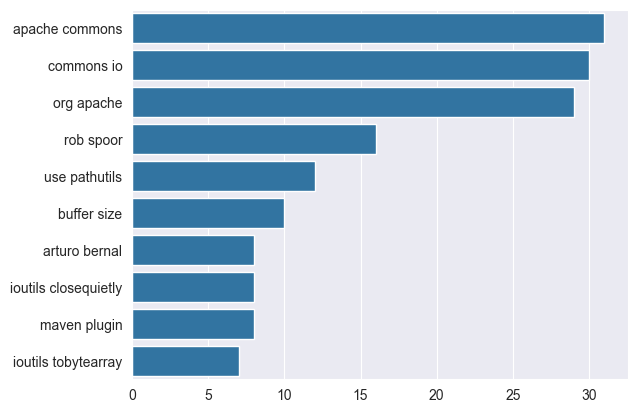

In [6]:
def get_n_gram(dt, n=None, stopwords='english'):
    dt = dt.dropna().astype(str)
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stopwords).fit(dt)
    # We get a sparse matrix corresponding to the occurrence of words per column
    sparse_matrix = vec.transform(dt)
    sum_words = sparse_matrix.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]


bi_grams = get_n_gram(data['Changes'], 2)

x, y = map(list, zip(*bi_grams))
sns.barplot(x=y, y=x)

#### Text exploration
We check the text properties such as length, most common words and distribution overall and per category. This includes stopwords since we are interested in the length of each release note.

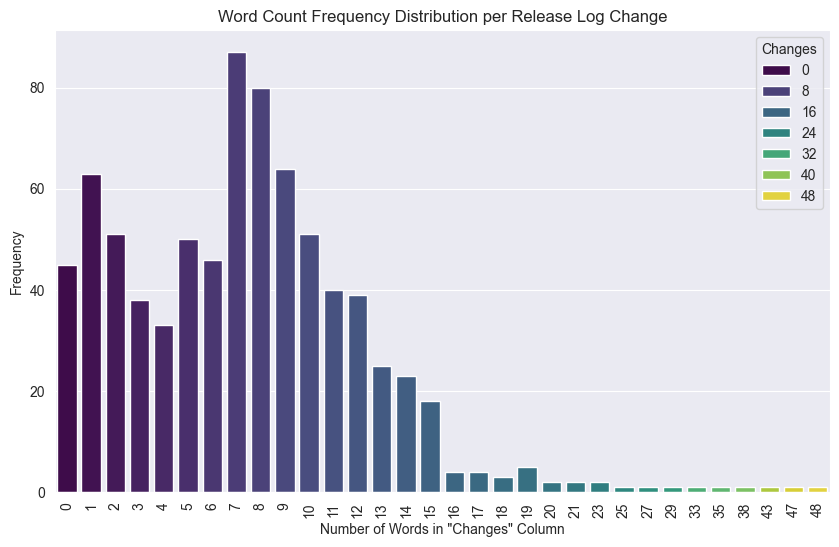

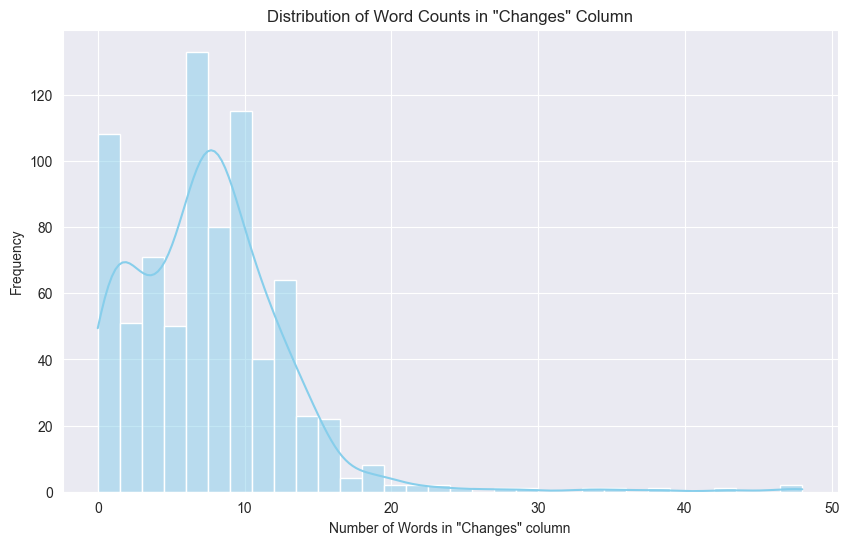

In [7]:
data_clean = data['Changes'].dropna().astype(str)
word_count = data_clean.str.split().apply(len)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=word_count.value_counts().index, y=word_count.value_counts().values, palette='viridis',
            hue=word_count.value_counts().index)
plt.title('Word Count Frequency Distribution per Release Log Change')
plt.xlabel('Number of Words in "Changes" Column')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(word_count, kde=True, color='skyblue')
plt.title('Distribution of Word Counts in "Changes" Column')
plt.xlabel('Number of Words in "Changes" column')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Most common words per category
from collections import Counter
from nltk.tokenize import word_tokenize


def separate_into_words(text):
    if isinstance(text, str):
        words_in_change = text.split()
        return [word.lower() for word in words_in_change if re.match(r'^[a-zA-Z]+$',
                                                                     word) and word.casefold() not in stop_words]
    else:
        return []


category_words = data.groupby('General Category')['Changes'].apply(
    lambda texts: [word for text in texts for word in separate_into_words(text)]
)

category_word_freq = category_words.apply(Counter)

for category, freq in category_word_freq.items():
    most_common = dict(freq.most_common(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(most_common.keys()), y=list(most_common.values()))

    file_name = category.replace(" ", "_")

    plt.title(f"Top Words in Category: {category}")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # plt.savefig(f"../resources/diagrams/top_words_{file_name}.png", format='png')

    # plt.show()
    plt.close()



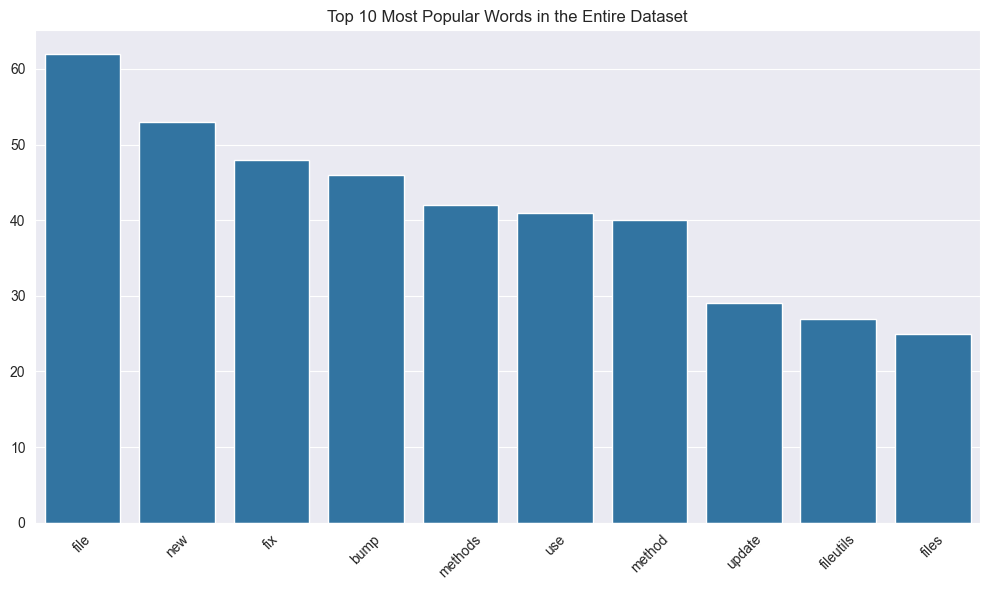

In [9]:
# Overall most popular words
all_words = [word for text in data['Changes'] for word in separate_into_words(text)]

word_freq = Counter(all_words)

most_common = dict(word_freq.most_common(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(most_common.keys()), y=list(most_common.values()))

plt.title("Top 10 Most Popular Words in the Entire Dataset")
plt.xticks(rotation=45)
plt.tight_layout()

# plt.savefig("../resources/diagrams/top_words_all.png", format='png')
plt.show()
plt.close()

#### Category distribution
We check how are the different categories are distributed over the release log changes.

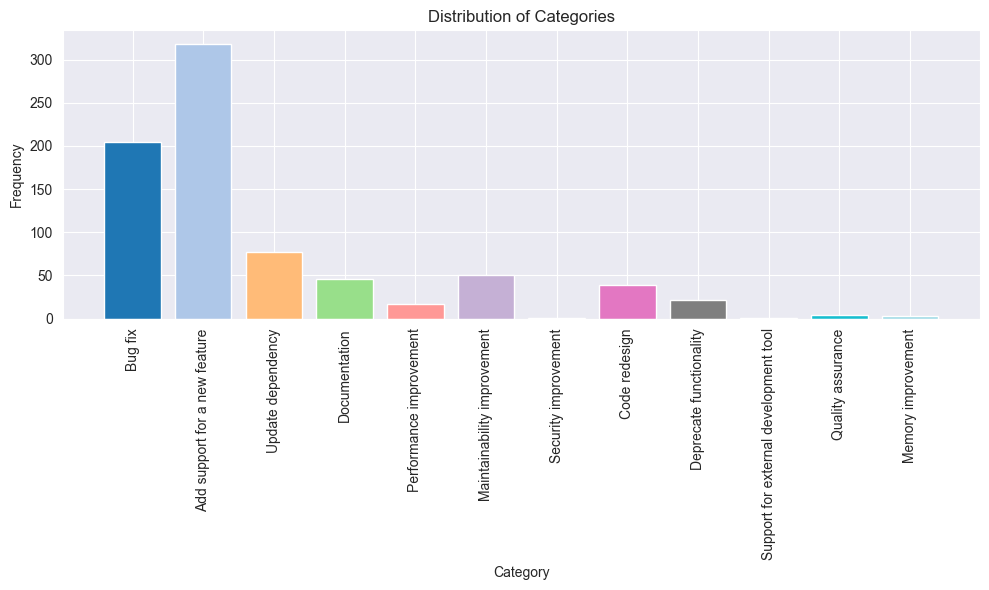

In [10]:
categories = data["General Category"].dropna().astype(str)
category_frequency = Counter(categories)
category_names = list(category_frequency.keys())
category_frequencies = list(category_frequency.values())

colors = plt.get_cmap("tab20", len(category_names))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x=category_names, height=category_frequencies, color=colors(np.arange(len(category_names))))

ax.set_title("Distribution of Categories")
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


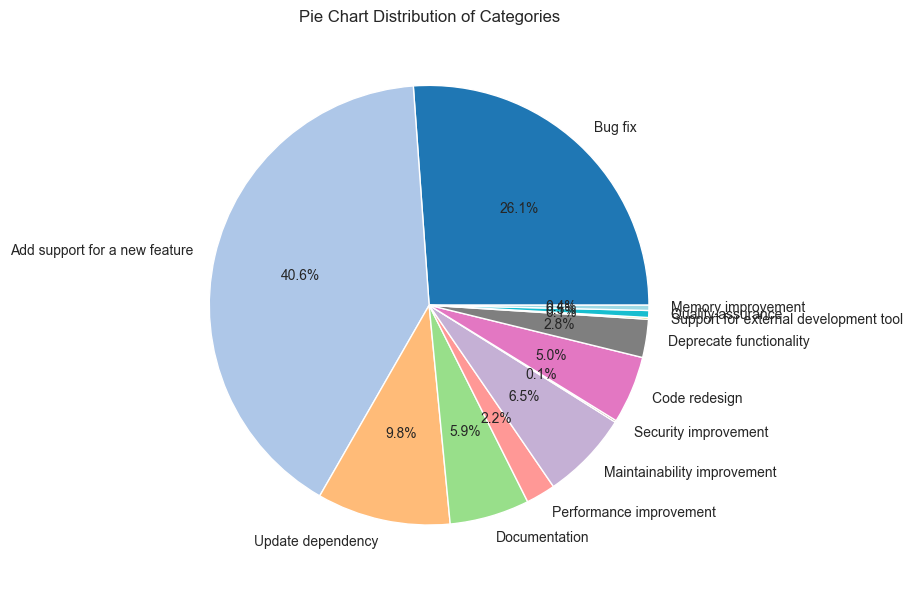

In [11]:
import os
import matplotlib.pyplot as plt
from collections import Counter

categories = data["General Category"].dropna().astype(str)
category_frequency = Counter(categories)
category_names = list(category_frequency.keys())
category_frequencies = list(category_frequency.values())

output_dir = "../resources/data-exploration"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

colors = plt.get_cmap("tab20", len(category_names))
fig, ax = plt.subplots(figsize=(10, 6))
pie_chart = ax.pie(category_frequencies, labels=category_names, colors=colors(np.arange(len(category_names))), autopct='%1.1f%%')

ax.set_title("Pie Chart Distribution of Categories")
plt.xticks(rotation=90)
plt.tight_layout()

file_path = os.path.join(output_dir, f"pie_chart_{dataset_name}.png")

plt.savefig(file_path, format='png')

plt.show()

plt.close()


In the next parts, we will focus on building the classifier.
### 2. Prepare the output
The next step is to stem and lemmatize the output. The stem reduces the word to its stem, while the lemmatizer alters the word in a way which that still preserves the meaning of the word. We explore both options in our experiment.

In [12]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()


def stematize_or_lemmatizer_input(is_stem=True):
    if is_stem:
        data["Adapted_Changes"] = data["Tokens"].apply(
            lambda tokens: [stemmer.stem(word) for word in tokens if isinstance(word, str)]
        )
    else:
        nltk.download('wordnet')
        data["Adapted_Changes"] = data["Tokens"].apply(
            lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
        )


# Here we remove all categories which have only one instance in the dataset, since this cannot work during the test split.
# category_counts = data['General Category'].value_counts()
#
# categories_with_multiple_occurrences = category_counts[category_counts > 1].index
#
# data = data[data['General Category'].isin(categories_with_multiple_occurrences)]

stematize_or_lemmatizer_input()
print("Adapted tokens: ")
print(data[["Tokens", "Adapted_Changes"]].head())

Adapted tokens: 
                                              Tokens  \
1  [regression, longer, creates, parent, director...   
2  [bytearrayorigin, able, convert, byte, bytearr...   
3  [throws, illegalstateexception, instead, nullp...   
4  [filealreadyexistsexception, path, linkoption,...   
5         [read, relevant, portion, file, long, int]   

                                     Adapted_Changes  
1  [regress, longer, creat, parent, directori, ch...  
2  [bytearrayorigin, abl, convert, byte, bytearra...  
3  [throw, illegalstateexcept, instead, nullpoint...  
4  [filealreadyexistsexcept, path, linkopt, filea...  
5            [read, relev, portion, file, long, int]  


### 3. Input processing
After clearing the input, the next step is to extract features which will be suitable for the machine learning model. For this, we use TF-IDF (Term Frequency-Inverse Document Frequency).


In [13]:
def return_vectorizer(name_of_vectorizer="tf_idf"):
    if name_of_vectorizer == "tf_idf":
        return TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 3))
    elif name_of_vectorizer == "bow":
        return CountVectorizer()


vectorizer = return_vectorizer()

print(data["Adapted_Changes"].head())

documents = data["Adapted_Changes"].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')

# print(documents.head())
X = vectorizer.fit_transform(documents)

print(X.shape)
print(X)

1    [regress, longer, creat, parent, directori, ch...
2    [bytearrayorigin, abl, convert, byte, bytearra...
3    [throw, illegalstateexcept, instead, nullpoint...
4    [filealreadyexistsexcept, path, linkopt, filea...
5              [read, relev, portion, file, long, int]
Name: Adapted_Changes, dtype: object
(784, 1000)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3988 stored elements and shape (784, 1000)>
  Coords	Values
  (0, 795)	0.3240141192199232
  (0, 589)	0.26980945631663106
  (0, 269)	0.264611051662453
  (0, 711)	0.28981478461192517
  (0, 310)	0.21746687139778414
  (0, 109)	0.3240141192199232
  (0, 964)	0.3240141192199232
  (0, 270)	0.3240141192199232
  (0, 712)	0.3098201129072192
  (0, 110)	0.3240141192199232
  (0, 271)	0.3240141192199232
  (1, 4)	0.4432377369209921
  (1, 253)	0.3849899775597532
  (1, 97)	0.2968645196221911
  (1, 5)	0.4432377369209921
  (1, 254)	0.4174626927948155
  (1, 6)	0.4432377369209921
  (2, 905)	0.38547089661777567
  (2, 491)	0.46474

### 4. Labels preparation
Once the data is prepared, the next step is to define the lables which will be used for categorization.

In [14]:
# TODO: I think here I should just hardcode the categories that we are searching
label_encoder = LabelEncoder()
print(data["General Category"].head())

y = label_encoder.fit_transform(data["General Category"])
print(y)
# print(label_encoder.classes_)
original_categories = label_encoder.inverse_transform(y)
# print(original_categories)
category_to_label = zip(original_categories, y)
category_to_label = [unique_tpl for unique_tpl in (set(tuple(pair) for pair in category_to_label))]
category_to_label.sort(key=lambda x: x[1])
print(category_to_label)

class_support = np.bincount(y)

classes_to_include = [cls for cls, support in enumerate(class_support) if support >= 0]
print(classes_to_include)

1    Bug fix
2    Bug fix
3    Bug fix
4    Bug fix
5    Bug fix
Name: General Category, dtype: object
[ 1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0 11  1  4  1  1
  1  1  7  4  5  1  4  1  4  5  1  1  1  1  1  1  1  1  9  1  5  5  5  2
  2  1  1  1  1  1  4  1  1  3  4  5  4  5  2  1  1  1  1  4  1  4  1  4
  5  1  1  1  5  1  4  4  1  1  2  4  1  2  2 10  0  0  0  0  0  0  0  0
  0  3  0  3  0  0  3  0  3  0  3  0  3  0  3  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  5  5  5 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  2  2  2  2  2  1  4  5
  5  5  5  2  1  5  0  8  0 11 11  1 11  1  0  0  0 11 11 11 11  4  1  1
  2  7  1  2  1  1  4  1  4  4  4  1  1  1  1  1  1  1  4  5  1  1  1  1
  0  2  2  0  0  0  0  0  5  0  0  0  0  1  0  0  0  2  0  0  2  5  0  0
  0  0  0  0  0  0 11

### 5. Split training and testing data
The next step is to prepare the training and testing data for the machine learning model. We use the 80/20 rule regarding the split between training and test and the random state 42, to ensure that the experiment is reproducible.

In [15]:
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(pd.Series(y_train_res).value_counts())
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

print("Training data shape: ", X_train.shape)
print("Test data: ", X_test.shape)


0     266
5     266
1     266
7     266
11    266
2     266
4     266
3     266
8     266
9     266
6     266
10    266
Name: count, dtype: int64
0     266
1     156
11     65
5      37
4      34
2      29
3      17
7      15
8       4
6       2
9       1
10      1
Name: count, dtype: int64
0     52
1     49
5     14
4     12
11    12
2     10
3      5
7      2
6      1
Name: count, dtype: int64
Training data shape:  (627, 1000)
Test data:  (157, 1000)


### Parameter Tuning
To improve the general performance of the models, now we experiment with tuning the parameters. (TODO: REORGANIZE THE SECTIONS)

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

print(data['General Category'].value_counts())
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def return_best_params(type, model, params):
    if type == "Grid":
        search_type = GridSearchCV(estimator=model, param_grid=params, cv=cvs, n_jobs=-1, verbose=2, scoring='f1_macro')
    elif type == "Random":
        search_type = RandomizedSearchCV(estimator=model, param_distributions=params, cv=cvs, n_iter=500,
                                         scoring='f1_macro',
                                         n_jobs=-1, random_state=42)

    search_type.fit(X_train_res, y_train_res)
    print(search_type.best_params_)

    return search_type.best_estimator_


General Category
Add support for a new feature            318
Bug fix                                  205
Update dependency                         77
Maintainability improvement               51
Documentation                             46
Code redesign                             39
Deprecate functionality                   22
Performance improvement                   17
Quality assurance                          4
Memory improvement                         3
Security improvement                       1
Support for external development tool      1
Name: count, dtype: int64


### 6. Train model
After the data is split and prepared, we then train the classifier. For this we use 3 different ML models for which we check the accuracy, precision, recall and F1 score of the model. We check the following in the next code blocks:(MAYBE CHANGE THE LAST 2 MODELS)
1. RandomForrestClassifier
2. SVN
3. Naive Bayes


#### 6.1. RandomForrestClassifier



In [17]:
# Desired Thresholds for metrics:
# Accuracy -> above 70%
# Precision -> above 70%
# Recall -> above 60%
# F1-score -> above 55%

param_grid_rfc = {
    'criterion': ['gini', 'log_loss'],
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 3],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'random_state': [42]
}

# rfc = RandomForestClassifier(class_weight="balanced", n_estimators=500, random_state=42, min_samples_split=10)
rfc = return_best_params("Grid", RandomForestClassifier(), param_grid_rfc)
rfc.fit(X_train_res, y_train_res)
y_pred_rfc = rfc.predict(X_test)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
{'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 1000, 'random_state': 42}


#### 6.2. Logistic Regression


In [18]:
param_grid_lrc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['saga', 'liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [2000, 5000, 10000],
    'class_weight': [None, 'balanced'],
    'random_state': [42]
}

lrc = return_best_params("Grid", LogisticRegression(), param_grid_lrc)
lrc.fit(X_train_res, y_train_res)
y_pred_lrc = lrc.predict(X_test)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'C': 100, 'class_weight': None, 'max_iter': 2000, 'random_state': 42, 'solver': 'liblinear'}


#### 6.3. SVC


In [19]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'class_weight': [None, 'balanced'],
    'max_iter': [2000, 5000, 10000],
    'random_state': [42]
}

svc = return_best_params("Grid", SVC(), param_grid_svc)
svc.fit(X_train_res, y_train_res)
y_pred_svc = svc.predict(X_test)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
{'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 2000, 'random_state': 42}


### 6.4 Stacking
Here we consider the usage of pipelines

In [20]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier

meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
sclf = StackingClassifier(
    estimators=[('rfc', rfc), ('lrc', lrc), ('svc', svc), ],
    final_estimator=meta_model
)
sclf.fit(X_train_res, y_train_res)
y_pred_sclf = sclf.predict(X_test)


### 6.5 Voting

In [21]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(
    estimators=[('rfc', rfc), ('lrc', lrc), ('svc', svc)],
    voting='hard'
)
vc.fit(X_train_res, y_train_res)
y_pred_vc = vc.predict(X_test)

### Performance Comparisons
In this section, we compare the performance of the different models, using the accuracy, recall, precision, F1 and confusion matrix

In [22]:
def compute_metrics(option_for_average, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average=option_for_average, zero_division=0)
    precision = precision_score(y_test, y_pred, average=option_for_average, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=option_for_average, zero_division=0)
    return accuracy, f1, precision, recall


def print_metrics(accuracy, f1, precision, recall):
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1-score:", f1)


def convert_to_df(classifiers_names, y_preds, option_for_average="macro", preprocessing_technique="Stem"):
    models = []
    accuracy_list = []
    f1_list = []
    precision_list = []
    recall_list = []

    for classifier_name, y_pred in zip(classifiers_names, y_preds):
        accuracy, f1, precision, recall = compute_metrics(option_for_average, y_pred)

        models.append(classifier_name)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        precision_list.append(precision)
        recall_list.append(recall)

    results_df = pd.DataFrame({
        "Classification name": models,
        "Accuracy": accuracy_list,
        "Precision": precision_list,
        "Recall": recall_list,
        "F1-score": f1_list,
        "Preprocessing technique": preprocessing_technique
    })
    return results_df


def show_classification_report(algorithm_name, y_pred):
    print("Results are for ", algorithm_name.__class__.__name__)
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


def plot_confusion_matrix(alg, y_pred):
    algorithm_name = alg.__class__.__name__
    print("Results are for", algorithm_name)
    output_dir = "../resources/confusion_matrices"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_path = os.path.join(output_dir, f"confusion_matrix_{dataset_name}_{algorithm_name}.png")

    fig, ax = plt.subplots(figsize=(8, 6))

    original_class_names = label_encoder.classes_
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(original_class_names)))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=original_class_names)
    cm_display.plot(cmap='Blues', values_format='d', ax = ax)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(file_path, format='png')
    plt.show()

### Converter to Latex
Here we use libraries to convert the obtained results directly to latex tables and graphs


In [23]:
def convert_to_table(df: pd.DataFrame):
    latex_table_code = df.to_latex(
        caption=f"Results for {dataset_name}",
        label="tab:...",
        column_format="p{3cm}p{3cm}p{3cm}p{3cm}p{3cm}p{3cm}",
        index=False,
        float_format="{:0.2f}".format
    )
    return latex_table_code


def convert_to_figure():
    pass



### Obtain results
After configuring the generation of tables and classifying models, we simply pass the parameters to a function which generates the required results.

In [24]:
y_preds = [y_pred_rfc, y_pred_svc, y_pred_vc, y_pred_sclf]
classifiers = [
    rfc.__class__.__name__,
    svc.__class__.__name__,
    vc.__class__.__name__,
    sclf.__class__.__name__
]
models=[rfc, svc, vc, sclf]
metrics_df = convert_to_df(classifiers_names=classifiers, y_preds=y_preds, option_for_average="macro",
                           preprocessing_technique="Stem")

latex_output = convert_to_table(metrics_df)

print(latex_output)

\begin{table}
\caption{Results for Apache Commons IO}
\label{tab:...}
\begin{tabular}{p{3cm}p{3cm}p{3cm}p{3cm}p{3cm}p{3cm}}
\toprule
Classification name & Accuracy & Precision & Recall & F1-score & Preprocessing technique \\
\midrule
RandomForestClassifier & 0.69 & 0.59 & 0.47 & 0.51 & Stem \\
SVC & 0.63 & 0.59 & 0.35 & 0.40 & Stem \\
VotingClassifier & 0.67 & 0.58 & 0.41 & 0.46 & Stem \\
StackingClassifier & 0.62 & 0.59 & 0.34 & 0.39 & Stem \\
\bottomrule
\end{tabular}
\end{table}



In [25]:
for cls,pred in zip(models, y_preds):
    show_classification_report(cls, pred)

Results are for  RandomForestClassifier
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.69      0.73        52
           1       0.78      0.80      0.79        49
           2       0.80      0.40      0.53        10
           3       0.80      0.80      0.80         5
           4       0.90      0.75      0.82        12
           5       0.83      0.36      0.50        14
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         0
          11       1.00      0.92      0.96        12

    accuracy                           0.69       157
   macro avg       0.59      0.47      0.51       157
weighted avg       0.79      0.69      0.73       157

Results are for  SVC
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.71      0.67        52
           1       0.68

Results are for RandomForestClassifier


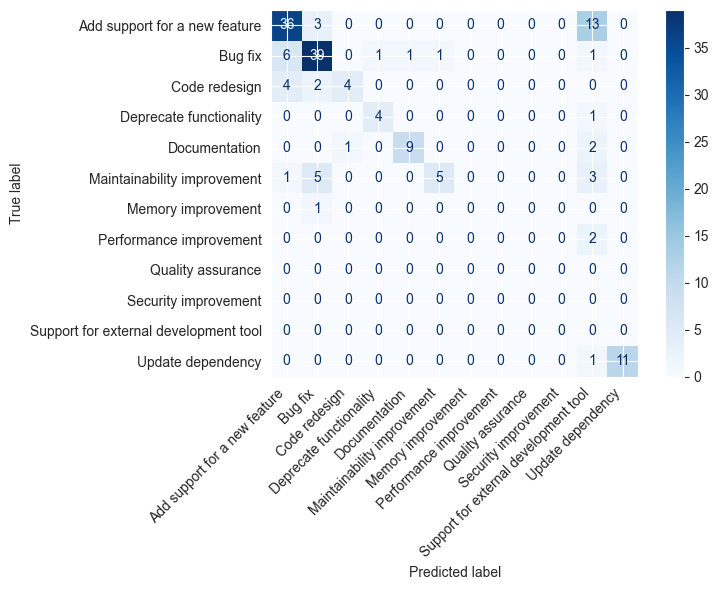

Results are for SVC


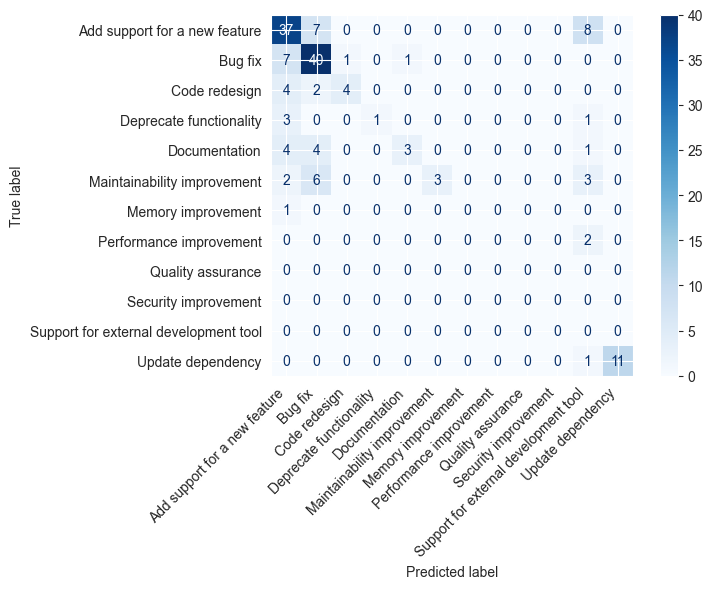

Results are for VotingClassifier


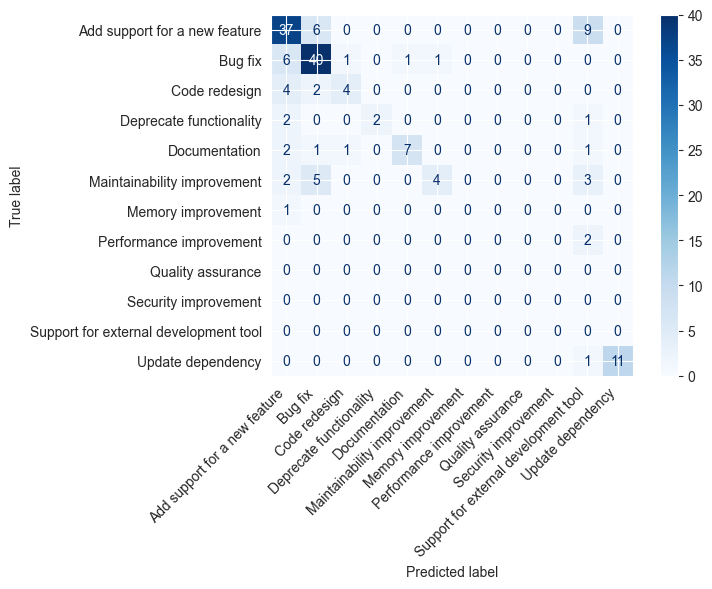

Results are for StackingClassifier


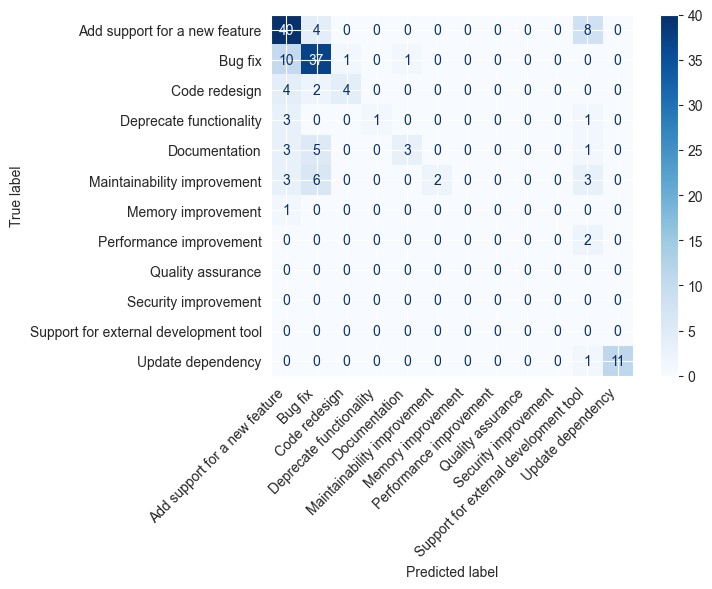

In [26]:
for cls,pred in zip(models, y_preds):
    plot_confusion_matrix(cls, pred)

### 7 Cross Validation Analysis
Once the model is trained, in the next section we evaluate it against a cross validation score. The reason for doing so is to attempt to increase the overall model performance on unseen data and limit the possibility of hyperparameter tuning.

In [27]:
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.metrics import make_scorer, precision_score, recall_score
# import numpy as np
#
# k_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#
# classifiers = [rfc, lrc, orc]
#
# precision_scorer = make_scorer(precision_score, average='macro', zero_division=1)
# recall_scorer = make_scorer(recall_score, average='macro', zero_division=1)
# f1_scorer = make_scorer(f1_score, average='macro', zero_division=1)
#
# for classifier in classifiers:
#     k_fold_score_accuracy = cross_val_score(classifier, X, y, cv=k_folds, scoring="accuracy")
#     k_fold_score_precision = cross_val_score(classifier, X, y, cv=k_folds, scoring=precision_scorer)
#     k_fold_score_recall = cross_val_score(classifier, X, y, cv=k_folds, scoring=recall_scorer)
#     k_fold_score_f1 = cross_val_score(classifier, X, y, cv=k_folds, scoring=f1_scorer)
#
#     print(f"Classifier: {classifier.__class__.__name__}")
#     print("K-Fold accuracy scores: ", k_fold_score_accuracy)
#     print("K-Fold accuracy mean score: ", np.mean(k_fold_score_accuracy))
#     print("K-Fold precision scores: ", k_fold_score_precision)
#     print("K-Fold precision mean score: ", np.mean(k_fold_score_precision))
#     print("K-Fold recall scores: ", k_fold_score_recall)
#     print("K-Fold recall mean score: ", np.mean(k_fold_score_recall))
#     print("K-Fold f1 scores: ", k_fold_score_f1)

### 8 Result Analysis
Here we explore the results to see which are the most common words per category.

### JUST A TEST

In [28]:
joblib.dump(rfc, "classifier_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

loaded_classifier = joblib.load("classifier_model.pkl")
loaded_vectorizer = joblib.load("vectorizer.pkl")

new_text = [
    "Source has been split into directories src/main/java and src/test/java, making it easier to exclude tests from builds, and making JUnit more maven-friendly"]
new_vector = loaded_vectorizer.transform(new_text)
prediction = loaded_classifier.predict(new_vector)

print("Predicted Category:", label_encoder.inverse_transform(prediction))


Predicted Category: ['Code redesign']
